## Project 6

In [147]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.cross_validation import KFold,cross_val_score,train_test_split,cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import scipy
import requests
from imdbpie import Imdb
import nltk
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
import nltk
import collections
import re
import csv
import psycopg2
import seaborn as sns
%matplotlib inline

### Problem Statement 

It is difficult to predict what factors lead to great movies as there are so many different aspects of movies that could be analyzed. Netflix would like to add some of the greatest movies of all time to its offerings and has asked us to help predict what sentiments go into the high ratings of these movies by viewers. In order to do this we are going to use the IMDB website to produce a random forest to predict what factors contribute most to ratings of some of the all-time great movies. 

In [49]:
#using imdbpie to connect to imdb and scrape data
imdb = Imdb()
imdb = Imdb(anonymize=True)

#### 2. Query the top 250 rated movies in the database

In [50]:
#importing the top 250 movies according to ratings on imdb
movies = imdb.top_250()
movies = pd.DataFrame(movies)
movies.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1677486,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1147737,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,784749,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1662731,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,858473,8.9,tt0108052,Schindler's List,feature,1993


|Column Name| Column Content|
|-----------|---------------|
|can_rate| whether a move can be rated online |
|image| url for an image associated wit the movie|
|num_votes| number of votes that a movie has received on imdb|
|rating| averagae user rating out of 10|
|tconst| ID for each movie|
|title| title of the movie|
|type| what kind of movie it was|
|year| what year the movie was released|

In [ ]:
### saving to csv in case we need to come back and don't want to use the internet
movies.to_csv('../Assets/Project 6/top250.csv', encoding='utf-8', index=False)

In [52]:
#saving the movie id's to a list so that we can iterate through the id's to get reviews
movieID = movies.tconst.values.tolist()

In [53]:
#using imbdpie to get 15 reviews for each of the top 250 movies by iterating through the movieID list
reviews = []
Id = []
for x in movieID:
    review = imdb.get_title_reviews(x, max_results=15)
    for i in review:
        Id.append(x)
        reviews.append(i.text)

In [54]:
#making a dataframe of the results of the reviews attached to their ID's
dfReviews = pd.DataFrame({'Id' : Id,
 'Review' : reviews})

In [55]:
print dfReviews.shape
dfReviews.head()

(3750, 2)


,Id,Review
0,tt0111161,Why do I want to write the 234th comment on Th...
1,tt0111161,"\nCan Hollywood, usually creating things for e..."
2,tt0111161,\nI have never seen such an amazing film since...
3,tt0111161,"In its Oscar year, Shawshank Redemption (writt..."
4,tt0111161,The reason I became a member of this database ...


In [56]:
#making all of the reviews string so that they are easier to deal with
dfReviews['Review'] = [BeautifulSoup(dfReviews['Review'][i], "lxml").get_text() for i in dfReviews.index]

In [57]:
from nltk.tokenize import RegexpTokenizer
#using nltk to tokenize the words from all the reviews so that we can analyze them
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
dfReviews['tokens'] = [tokenizer.tokenize(i) for i in dfReviews.Review]

In [58]:
dfReviews.head()

,Id,Review,tokens
0,tt0111161,Why do I want to write the 234th comment on Th...,"[Why, do, I, want, to, write, the, 234th, comm..."
1,tt0111161,"Can Hollywood, usually creating things for ent...","[Can, Hollywood, ,, usually, creating, things,..."
2,tt0111161,I have never seen such an amazing film since I...,"[I, have, never, seen, such, an, amazing, film..."
3,tt0111161,"In its Oscar year, Shawshank Redemption (writt...","[In, its, Oscar, year, ,, Shawshank, Redemptio..."
4,tt0111161,The reason I became a member of this database ...,"[The, reason, I, became, a, member, of, this, ..."


In [59]:
#list of words from tokens that also tags words with parts of speech so that we can isolate descriptive words
tags = []
for i in dfReviews['tokens']:
    tags.append(nltk.pos_tag(i))

In [60]:
print len(tags)

3750


In [61]:
#appends all words that are adjectives, or descriptive to list
adjList = []
for x in tags:
    for word, pos in x:
        if pos in ['JJ', 'JJS', 'JJR']: 
            adjList.append(word) #appends all words that are adjectives, or descriptive to list

In [62]:
print len(adjList)

124605


In [63]:
from collections import Counter

In [64]:
#list of most common descriptive words as identified by part of speech tagging
Counter(adjList).most_common()

[(u'great', 2479),
 (u'other', 2118),
 (u'best', 2116),
 (u'good', 2114),
 (u'many', 1926),
 (u'first', 1798),
 (u'more', 1692),
 (u'much', 1151),
 (u'such', 1132),
 (u'same', 1077),
 (u'own', 1071),
 (u'real', 1032),
 (u'little', 989),
 (u'most', 930),
 (u'few', 850),
 (u'old', 795),
 (u'true', 773),
 (u'new', 769),
 (u'last', 710),
 (u'young', 704),
 (u'different', 701),
 (u'perfect', 699),
 (u'human', 668),
 (u'bad', 667),
 (u'better', 646),
 (u'big', 629),
 (u'excellent', 576),
 (u"'t", 575),
 (u'greatest', 575),
 (u'whole', 574),
 (u'beautiful', 567),
 (u'only', 559),
 (u'classic', 553),
 (u'original', 535),
 (u'long', 530),
 (u'brilliant', 526),
 (u'hard', 499),
 (u'wonderful', 492),
 (u'least', 486),
 (u'main', 479),
 (u'second', 473),
 (u'American', 463),
 (u'powerful', 460),
 (u'full', 438),
 (u'special', 428),
 (u'final', 423),
 (u'funny', 415),
 (u'black', 415),
 (u'entire', 411),
 (u'important', 410),
 (u'right', 407),
 (u'top', 407),
 (u'sure', 401),
 (u'high', 398),
 (u'e

In [65]:
words = (u'great', u'good', u'best', u'much',u'real',u'perfect',u'better',u'excellent',u'beautiful',u'fascinating'
        ,u'flawless',u'extraordinary',u'greatest',u'classic',u'brilliant',u'wonderful',u'powerful',u'special',u'important'
        ,u'strong') 
#using hand picked 20 common descriptors that seem to denote the reviewer's feeling on the movie, where the meaning
#is less likely to be misconstrued as positive when it could have been used negatively

In [66]:
#creating dataframe to append to reviews that will use 1's and 0's to tell whether the movies reviews contained the word
dfCommonAdj = pd.DataFrame(columns=words)
dfCommonAdj

,great,good,best,much,real,perfect,better,excellent,beautiful,fascinating,flawless,extraordinary,greatest,classic,brilliant,wonderful,powerful,special,important,strong


In [67]:
#joining review dataframe and the commonAdj dataframe
reviewDataCopy = pd.DataFrame(dfReviews)
reviewDataCopy = reviewDataCopy.join(dfCommonAdj)

In [68]:
reviewDataCopy.head()

,Id,Review,tokens,great,good,best,much,real,perfect,better,...,flawless,extraordinary,greatest,classic,brilliant,wonderful,powerful,special,important,strong
0,tt0111161,Why do I want to write the 234th comment on Th...,"[Why, do, I, want, to, write, the, 234th, comm...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0111161,"Can Hollywood, usually creating things for ent...","[Can, Hollywood, ,, usually, creating, things,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0111161,I have never seen such an amazing film since I...,"[I, have, never, seen, such, an, amazing, film...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0111161,"In its Oscar year, Shawshank Redemption (writt...","[In, its, Oscar, year, ,, Shawshank, Redemptio...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0111161,The reason I became a member of this database ...,"[The, reason, I, became, a, member, of, this, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
#putting a 1 or a 0 in each column for each review if the word is present in the review
for c, col in enumerate(reviewDataCopy.columns[2:]):
    for r, row in enumerate(reviewDataCopy.index):
        reviewLower = reviewDataCopy.loc[row,"Review"].lower()
        if (col in reviewLower):
            reviewDataCopy.loc[row,col] = 1
        else:
            reviewDataCopy.loc[row,col] = 0

In [70]:
reviewDataCopy.head()

,Id,Review,tokens,great,good,best,much,real,perfect,better,...,flawless,extraordinary,greatest,classic,brilliant,wonderful,powerful,special,important,strong
0,tt0111161,Why do I want to write the 234th comment on Th...,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
1,tt0111161,"Can Hollywood, usually creating things for ent...",0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,1,0,1,1
2,tt0111161,I have never seen such an amazing film since I...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,tt0111161,"In its Oscar year, Shawshank Redemption (writt...",0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,tt0111161,The reason I became a member of this database ...,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
#making a new dataframe grouped by Id, so that we can later merge it with the original dataframe and compare the ratings
#to the words contained in reviews
newDF = reviewDataCopy.groupby(["Id"], group_keys=False, as_index=False).apply(lambda x: x.iloc[:,2:].max())

In [72]:
#don't need this column any more
newDf = newDF.drop('tokens', axis=1)

In [73]:
#joining to original dataframe to compare words used in reviews to ratings and other metrics
movies = movies.join(newDf)

In [74]:
movies.head()

,can_rate,image,num_votes,rating,tconst,title,type,year,great,good,...,flawless,extraordinary,greatest,classic,brilliant,wonderful,powerful,special,important,strong
0,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1677486,9.3,tt0111161,The Shawshank Redemption,feature,1994,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1147737,9.2,tt0068646,The Godfather,feature,1972,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,784749,9.0,tt0071562,The Godfather: Part II,feature,1974,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1662731,9.0,tt0468569,The Dark Knight,feature,2008,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,858473,8.9,tt0108052,Schindler's List,feature,1993,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [75]:
#dropping columns we don't need to analyze the ratings 
movies.drop(['can_rate','image','tconst','type'], axis=1, inplace=True)

In [84]:
movies.head()

,num_votes,rating,title,year,great,good,best,much,real,perfect,...,flawless,extraordinary,greatest,classic,brilliant,wonderful,powerful,special,important,strong
0,1677486,9.3,The Shawshank Redemption,1994,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,1147737,9.2,The Godfather,1972,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,784749,9.0,The Godfather: Part II,1974,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,1662731,9.0,The Dark Knight,2008,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,858473,8.9,Schindler's List,1993,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [76]:
#saving so that I don't have to access IMDB again
movies.to_csv('../Assets/Project 6/top250Final.csv', encoding='utf-8', index=False)

## Part 3: Combine Tables in PostgreSQL

I joined the tables in pandas and did not need to push to postgres to combine them. Also, others would not be able to access my local postgres database unless my machine were on.

In [78]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 24 columns):
num_votes        250 non-null int64
rating           250 non-null float64
title            250 non-null object
year             250 non-null object
great            250 non-null float64
good             250 non-null float64
best             250 non-null float64
much             250 non-null float64
real             250 non-null float64
perfect          250 non-null float64
better           250 non-null float64
excellent        250 non-null float64
beautiful        250 non-null float64
fascinating      250 non-null float64
flawless         250 non-null float64
extraordinary    250 non-null float64
greatest         250 non-null float64
classic          250 non-null float64
brilliant        250 non-null float64
wonderful        250 non-null float64
powerful         250 non-null float64
special          250 non-null float64
important        250 non-null float64
strong           250 non-

All of the information contained in the table is in the format that we expect it to be, except the year which is an object, but we will normalize it later so it isn't an issue.

In [79]:
movies.describe()

,num_votes,rating,great,good,best,much,real,perfect,better,excellent,...,flawless,extraordinary,greatest,classic,brilliant,wonderful,powerful,special,important,strong
count,2.500000e+02,250.00000,250.0,250.000000,250.0,250.0,250.0,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.0000,250.000000,250.000000,250.000000
mean,4.028417e+05,8.31560,1.0,0.992000,1.0,1.0,1.0,0.976000,0.964000,0.884000,...,0.440000,0.340000,0.740000,0.836000,0.900000,0.848000,0.7200,0.960000,0.780000,0.824000
std,3.303321e+05,0.23206,0.0,0.089263,0.0,0.0,0.0,0.153356,0.186664,0.320867,...,0.497383,0.474659,0.439514,0.371018,0.300602,0.359741,0.4499,0.196352,0.415077,0.381584
min,2.560900e+04,8.00000,1.0,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
25%,1.226788e+05,8.10000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0000,1.000000,1.000000,1.000000
50%,3.231085e+05,8.30000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000
75%,5.939085e+05,8.40000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000
max,1.677486e+06,9.30000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000


The desciptition of the columns of data are also what you would expect.

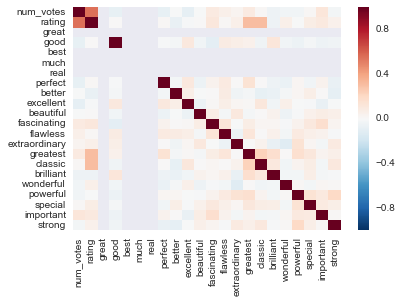

In [83]:
sns.heatmap(movies.corr())

The highest correlation with the rating of a movie is very clearly the number or votes that a movie recieved. This is a bit of a warning flag that perhaps this information is biased, with only people who rate a movie highly writing reviews for movies. The strongest word correlations are with the words "greatest" and "classic". the other words do not have much of a positive correlation with the rating of a movie.

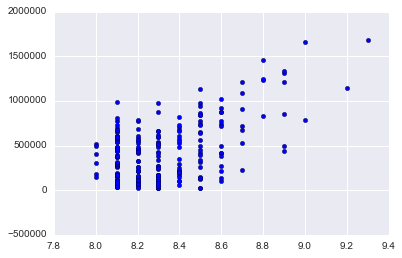

In [157]:
plt.scatter(movies.rating, movies.num_votes)

This is just a scatter plot of the above correlation between ratings and number of votes. We can see that this correlation also may be driven largely by a smaller group og movies with very high ratings. 

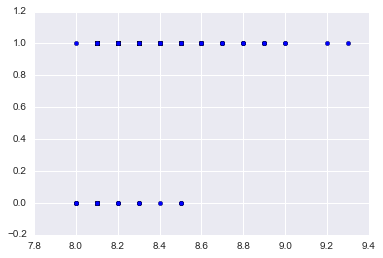

In [163]:
plt.scatter(movies.rating, movies.classic)

Just a visualization of the correlation of the word "classic" being in a review and the rating of a movie. Movies with ratings below 8.6 do not get called classic in their reviews.  

(array([ 54.,  38.,  23.,  15.,  18.,  23.,  19.,  16.,   9.,  11.,   7.,
          5.,   1.,   2.,   4.,   2.,   0.,   1.,   0.,   2.]),
 array([   25609.  ,   108202.85,   190796.7 ,   273390.55,   355984.4 ,
          438578.25,   521172.1 ,   603765.95,   686359.8 ,   768953.65,
          851547.5 ,   934141.35,  1016735.2 ,  1099329.05,  1181922.9 ,
         1264516.75,  1347110.6 ,  1429704.45,  1512298.3 ,  1594892.15,
         1677486.  ]),
 <a list of 20 Patch objects>)

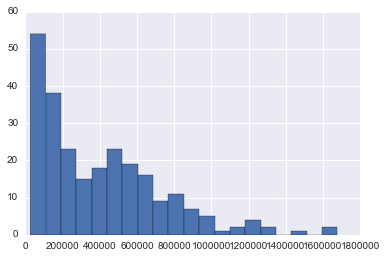

In [187]:
plt.hist(movies.num_votes, bins=20)


Along with normalizing the year, we have a large irregular data set with the number of votes, which has a right skew, so we will also normalize that.

## Part 3: Build the Decision Tree

#### 1. What is our target attribute? 

#### 2. Prepare the data and define the training set

In [95]:
#creating our target variable y(rating) and using all other columns as predictors of y (the rating)
y=movies['rating']
X= movies.drop(['rating','title'], axis=1)

In [96]:
X.head()

,num_votes,year,great,good,best,much,real,perfect,better,excellent,...,flawless,extraordinary,greatest,classic,brilliant,wonderful,powerful,special,important,strong
0,1677486,1994,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,1147737,1972,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,784749,1974,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,1662731,2008,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,858473,1993,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [97]:
#normalizing year
X['year'] = MinMaxScaler().fit_transform(X.year.astype(float).reshape(-1,1))
X.head()

,num_votes,year,great,good,best,much,real,perfect,better,excellent,...,flawless,extraordinary,greatest,classic,brilliant,wonderful,powerful,special,important,strong
0,1677486,0.768421,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,1147737,0.536842,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,784749,0.557895,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,1662731,0.915789,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,858473,0.757895,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [173]:
#normalizing number of votes
X['num_votes'] = MinMaxScaler().fit_transform(X.num_votes.astype(float).reshape(-1,1))
X.head()

,num_votes,year,great,good,best,much,real,perfect,better,excellent,...,flawless,extraordinary,greatest,classic,brilliant,wonderful,powerful,special,important,strong
0,1.000000,0.768421,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.679305,0.536842,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,0.459562,0.557895,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,0.991068,0.915789,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,0.504193,0.757895,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [175]:
#splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)

#### 2. Train the Model

In [176]:
cv = KFold(len(y_train), shuffle=False) #fitting a decision tree model
print cv
dt = DecisionTreeRegressor(random_state=5)
dtScore = cross_val_score(dt, X_train, y_train, cv=cv,n_jobs=1)
print "Regular Decision Tree scores are:", dtScore
print "Regular Decision Tree average score is:", dtScore.mean()

sklearn.cross_validation.KFold(n=175, n_folds=3, shuffle=False, random_state=None)
Regular Decision Tree scores are: [-0.34215051 -0.11223726  0.03055556]
Regular Decision Tree average score is: -0.141277404163


Here we have used optimized cross validation to produce a regular decision tree model of the predictor data. the average score for the model is not good. The fact that the model has a negative value means that it is worse than a random guess and does not explain any of the variance of the data set. We will have to explore further variations of decision tree models to see whether they can be better predictors of the ratings of a top 250 movie.

In [177]:
rf = RandomForestRegressor(random_state=5)
rfScore = cross_val_score(rf, X_train,y_train, cv=cv, n_jobs=1)
print "Random Forest scores are:", rfScore
print "Regular Decision Tree scores are:", dtScore
print "Random Forest average score is:", rfScore.mean()
print "Regular Decision Tree average score is:", dtScore.mean()

Random Forest scores are: [ 0.42619164  0.29581687  0.46016667]
Regular Decision Tree scores are: [-0.34215051 -0.11223726  0.03055556]
Random Forest average score is: 0.394058393668
Regular Decision Tree average score is: -0.141277404163


In order to address the short falls of a single decision tree, we can use a random forest. This model creates a large group of decision trees and averages the output of each decision tree in order to give a predicted value. In this case the random forest is able to explain about 40% of the variance of the model is better than random guessing. while there is still room for improvement this is vastly better than the previous models predictions.

In [178]:
ab = AdaBoostRegressor(random_state=5)
abScore = cross_val_score(ab, X_train,y_train, cv=cv, n_jobs=1)
print "Adaptive Boost scores are :",abScore
print "Random Forest scores are:", rfScore
print "Regular Decision Tree scores are:", dtScore
print "Average Boost average score is:",abScore.mean()
print "Random Forest average score is:", rfScore.mean()
print "Regular Decision Tree average score is:", dtScore.mean()

Adaptive Boost scores are : [ 0.28127231  0.37688004  0.43764208]
Random Forest scores are: [ 0.42619164  0.29581687  0.46016667]
Regular Decision Tree scores are: [-0.34215051 -0.11223726  0.03055556]
Average Boost average score is: 0.365264808045
Random Forest average score is: 0.394058393668
Regular Decision Tree average score is: -0.141277404163


Another strategy that we can use is adaptive boost. This model also makes multiple decision trees, but bases each successive decision tree model on fixing the areas of greatest error in the previous model. This approach is also much better than the original decision tree model, but does not perform quite as well as the random forest. 

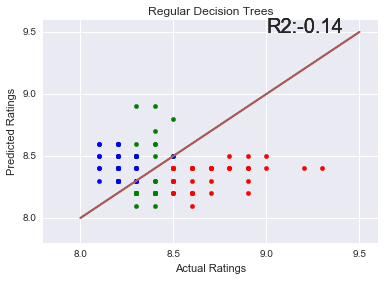

In [179]:
def do_plot(model, m=None):
    for fold, color in zip(cv, ['r','g','b']):#colors are from different folds from Kfold, so 3 diff models
        
        X_train = X.iloc[fold[0]]
        X_test =  X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        plt.scatter(y_test, y_pred, color=color)
        plt.plot([8.0,9.5],[8.0,9.5])
        plt.text(9,9.5, "R2:"+str(m), fontsize=20, )
        plt.xlabel('Actual Ratings')
        plt.ylabel('Predicted Ratings')
        
        
do_plot(dt, dtScore.mean().round(2))
plt.title("Regular Decision Trees")

Here we can see the results of the regular decision tree model. The blue, green and red dots represent predicted values from the 3-fold (hence 3 sets of predicted values) cross-validated model. The green model seems to be the best fit, but the red and blue models make it almost sure that the predicted value will not be close to the actual movie rating. this demonstrates how you can have a model that is worse than random guessing.

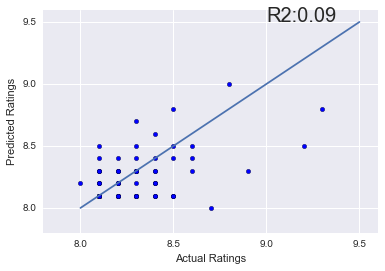

In [180]:
def do_plot2(model):
   
       
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        plt.scatter(y_test, y_pred)
        plt.plot([8.0,9.5],[8.0,9.5])
        plt.text(9,9.5, "R2:"+str(r2_score(y_test,y_pred).round(2)), fontsize=20, )
        plt.xlabel('Actual Ratings')
        plt.ylabel('Predicted Ratings')
do_plot2(dt)        

Just out of curiosity, I plotted a regular decision tree model without crossvalidation. This model performed substantially better than the cross-validated one. However, it is only barely better than chance. This may be an indication that our model is over-fit to our data.

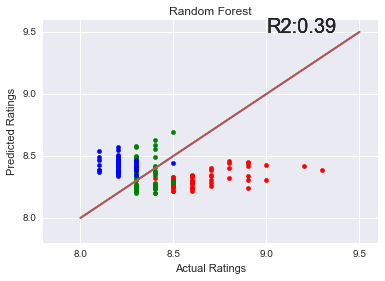

In [181]:
do_plot(rf, rfScore.mean().round(2))
plt.title("Random Forest")

This is a representation of the Random Forest cross-validated model. The model has a much better score than the regular decision tree, but as you can see two of the models (blue and red) appear very poor. This also may be a sign that we are over-fitting our model.

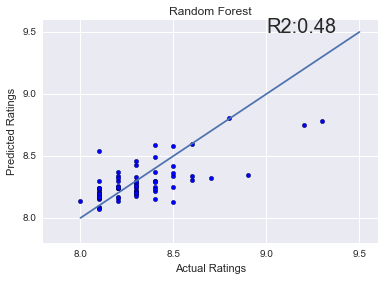

In [182]:
do_plot2(rf)
plt.title("Random Forest")

This is a representation of the random forest model without using cross-validation. This model has about a 25% better score than the previous cross-validated model. Cross-validation appears to be over fitting our model to our training set, or our predictors are not very good, so that when they are split up they are even worse at predicting ratings.

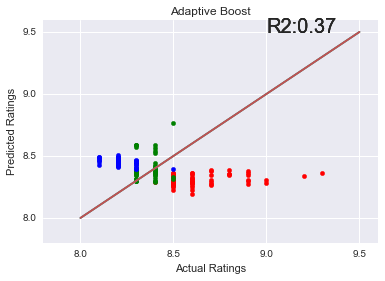

In [183]:
do_plot(ab, abScore.mean().round(2))
plt.title("Adaptive Boost")

This is a representation of the adaptive boost cross-validated model. The model has a much better score than the regular decision tree as well, but as you can see none of the models appear very accurate. This also may be a sign that there are problems with this model as well. 

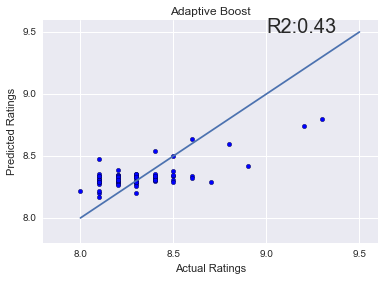

In [184]:
do_plot2(ab)
plt.title("Adaptive Boost")

This is the adaptive boost model without cross-validation. Again we see improvement with removal of cross-validation. This means that there are probably only a few predictors that are actually good at predicting ratings. When they are split up into different models, they are making some models that have bad predictive ability, so even when they are averaged together, the bad models are pulling the score down.

We also may be over-fitting the line. For a regression line, the measure for each deciesion at each branch is the mean squared error, which decreases as the degrees (the number of variables you use as predictors) of your model increase. Therefore it is very tempting to choose a huge number of words to try to predict ratings of movies, but as the number of words you choose increase, the liklihood of your model being overfit increases as well as the MSE is reduced further and further. 

#### Project Summary

Our models are ok at guessing ratings of movies based on the limited sentiment/characteristics present in our analysis of top 250 movie ratings. These models strongest predictors are likely not the words we have picked out, but the number of reviews and the year. There were very few words that had strong correlations with increased ratings. We have some ability to tell whether a movie will have a great rating, but further analysis is needed. While this project did not provide us with a great model off the bat, it has provided us with future directions to produce a better model.

One future direction is to study more about our word choice. Perhaps adjectives are not the best words for use in this type of model. I would reccommend doing a study to pull out more words, perhaps words about the subject matter of the movie (maybe nouns?), as opposed to words that are more subjectively used by reviewers, such as adjectives. Additionally, there is the problem of inherent bias in dataset such as one generated by voluntary reviews. Voluntary reviewers likely only write reviews if they happen to visit that website, or are more passionate about movies than the average viewer.

Another direction would be to focus on more quantifiable metrics. We could focus on actors in the movies, or the run-time. These metrics strength is that they are non-subjective and are much less likely to be interpreted incorrectly. We could also use data about the average background color of a movie, or face time for actors. These metrics may prevent misinterpretation and overfitting by adding excessive words as predictors of a movies ratings.

In addition, we have only analyzed good movies, so we do not know the characteristics of a bad movie. If we do not examine bad movies, our data is likely to skew us to a higher rating as we do not have a true baseline for an average movie.

In conclusion, we would recommend further studies to first identify the best metrics with the highest correlation to the top rated movies. Additionally we reccomend that more movies be included so that we can better differentiate good movies from bad movies from great movies.

